In [1]:
import torch
from torch import nn #nn contains all of PyTorch's  building blocks for Neural Networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.9.0+cu126'

## 1. Data (preparing and loading)

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with known **parameters**.

In [2]:
# Create *known* params
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(15, 10))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  plt.legend(prop={"size": 14})
  plt.xlabel("X")
  plt.ylabel("y")

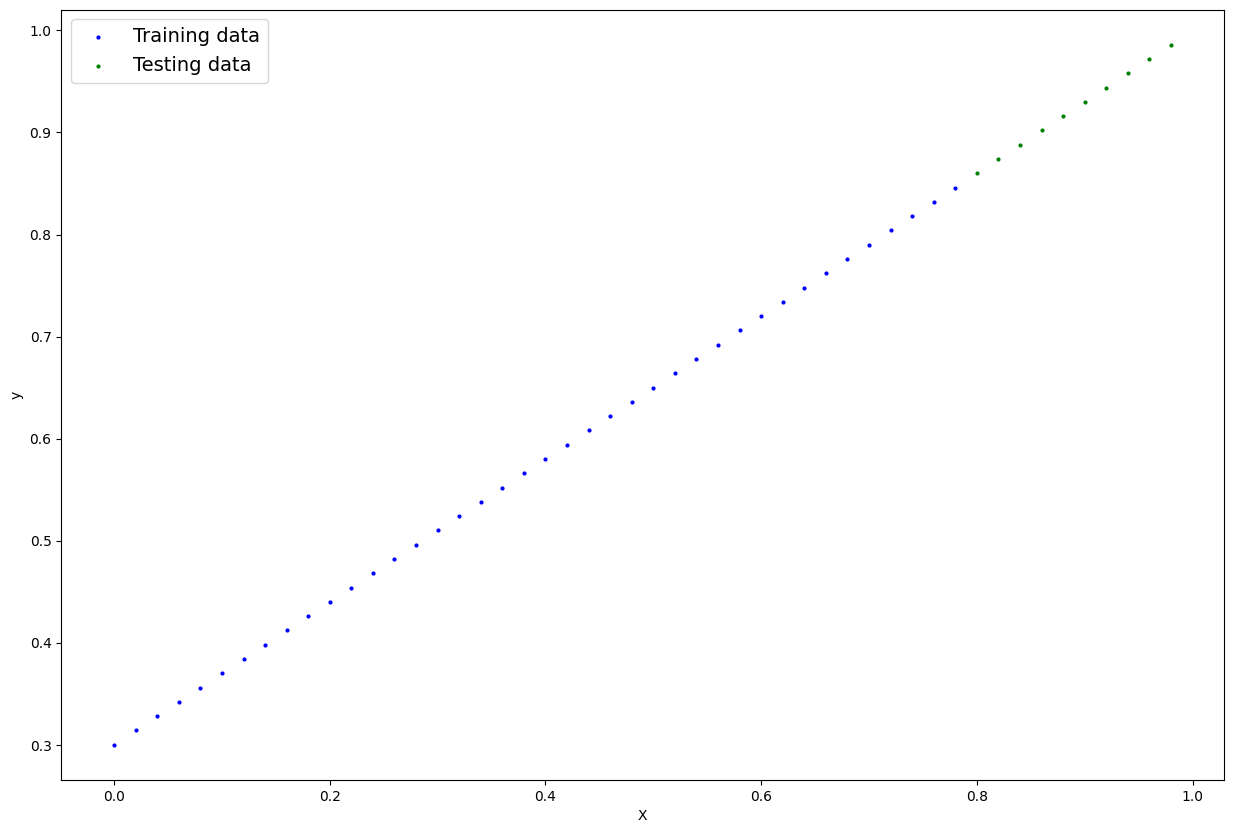

In [6]:
plot_predictions();

In [7]:
class LinearRegressionModel(nn.Module): # <- Almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x + self.bias #linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs(a NN can be considered as a computational graph)
* torch.nn.Parameter - what params should our model try and learn, of a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where PyTorch optimizers live, they will help with gradient descent

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model params using `.parameters()`

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an isntance of the model(this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check the model parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

In [10]:
# Make predictions with model
with torch.inference_mode(): # If one uses inference_mode() it makes the code faster
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [11]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

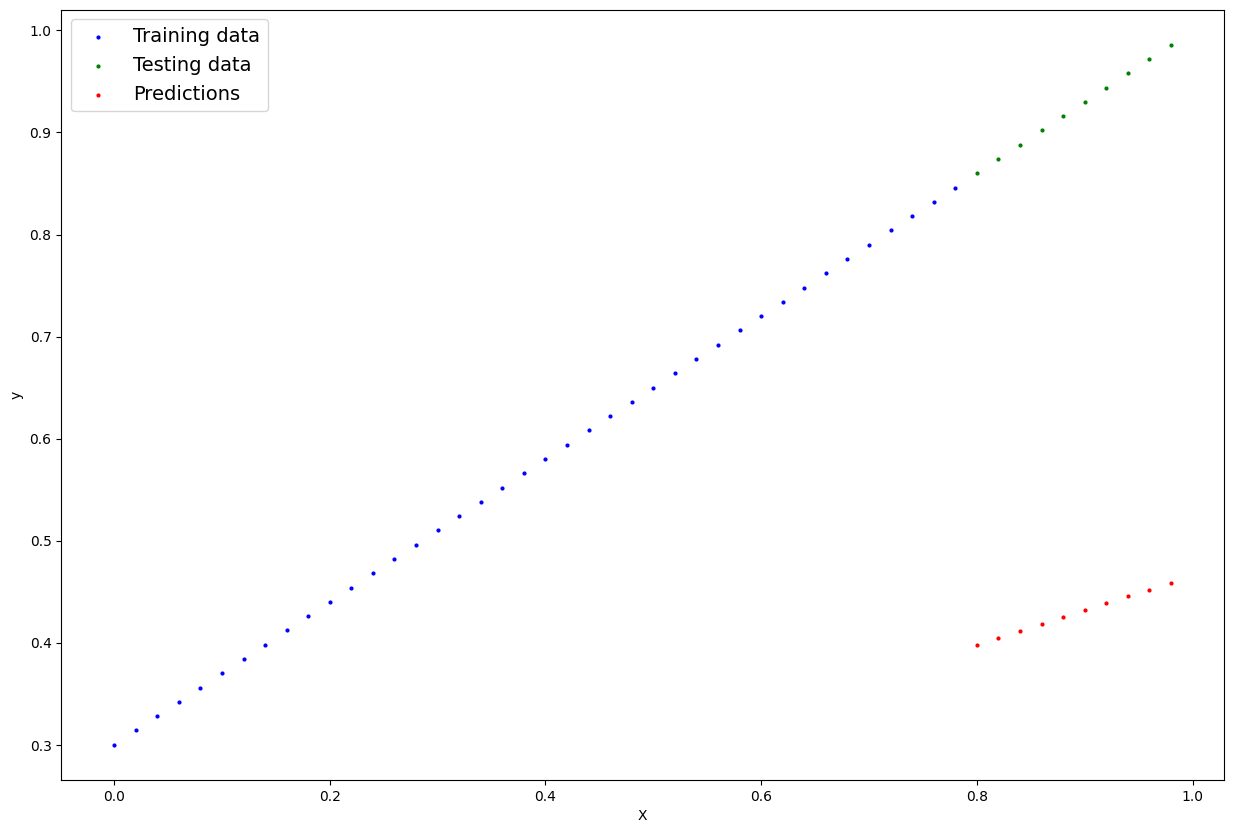

In [12]:
plot_predictions(predictions = y_preds)

## 3. Train a model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some known parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.
Things we need to train:

* **Loss function**: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://pytorch.org/docs/stable/optim.html#module-torch.optim
Inside the optimizer you'll often have to set two parameters:
params - the model parameters you'd like to optimize, for example params=model_0.parameters()
lr (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small lr results in small changes, a large lr results in large changes)
And specifically for PyTorch, we need:

* A training loop
* A testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves our data moving through our model's  `forward()` function) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss(**back propagation**)
5. Optimizer step - use the optimizer to adjust our model's parameter to try and improve the loss(**gradient descent**)

In [16]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 1600

# Track different values
epoch_count = []
loss_values =[]
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to traning mode
  model_0.train() # train mode in PyTorch sets all params that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the params of the model
  loss.backward()

  # 5. Optimizer step (perform gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & couple of more behind the scenes things
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4931890368461609
OrderedDict({'weights': tensor([0.3371]), 'bias': tensor([0.1298])})
Epoch: 10 | Loss: 0.3013603389263153 | Test loss: 0.4797181189060211
OrderedDict({'weights': tensor([0.3410]), 'bias': tensor([0.1398])})
Epoch: 20 | Loss: 0.28983938694000244 | Test loss: 0.4662471413612366
OrderedDict({'weights': tensor([0.3449]), 'bias': tensor([0.1498])})
Epoch: 30 | Loss: 0.2783183455467224 | Test loss: 0.4527761936187744
OrderedDict({'weights': tensor([0.3488]), 'bias': tensor([0.1598])})
Epoch: 40 | Loss: 0.26679736375808716 | Test loss: 0.43930521607398987
OrderedDict({'weights': tensor([0.3527]), 'bias': tensor([0.1698])})
Epoch: 50 | Loss: 0.2552763819694519 | Test loss: 0.4258342385292053
OrderedDict({'weights': tensor([0.3566]), 'bias': tensor([0.1798])})
Epoch: 60 | Loss: 0.24375538527965546 | Test loss: 0.41236335039138794
OrderedDict({'weights': tensor([0.3605]), 'bias': tensor([0.1898])})
Epoch: 70 | Loss: 0.232234388

/tmp/ipython-input-3556260778.py:3: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")


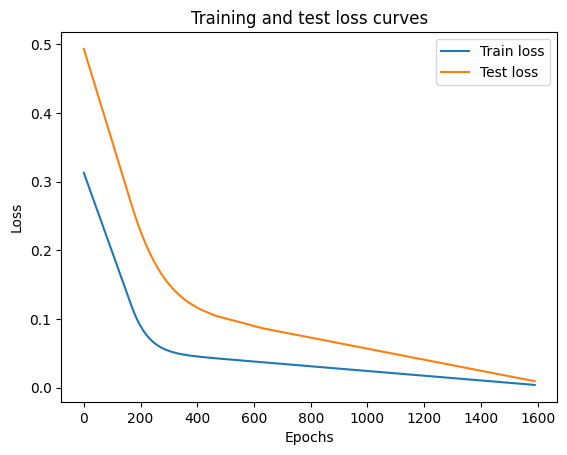

In [17]:
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6813])), ('bias', tensor([0.3078]))])

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

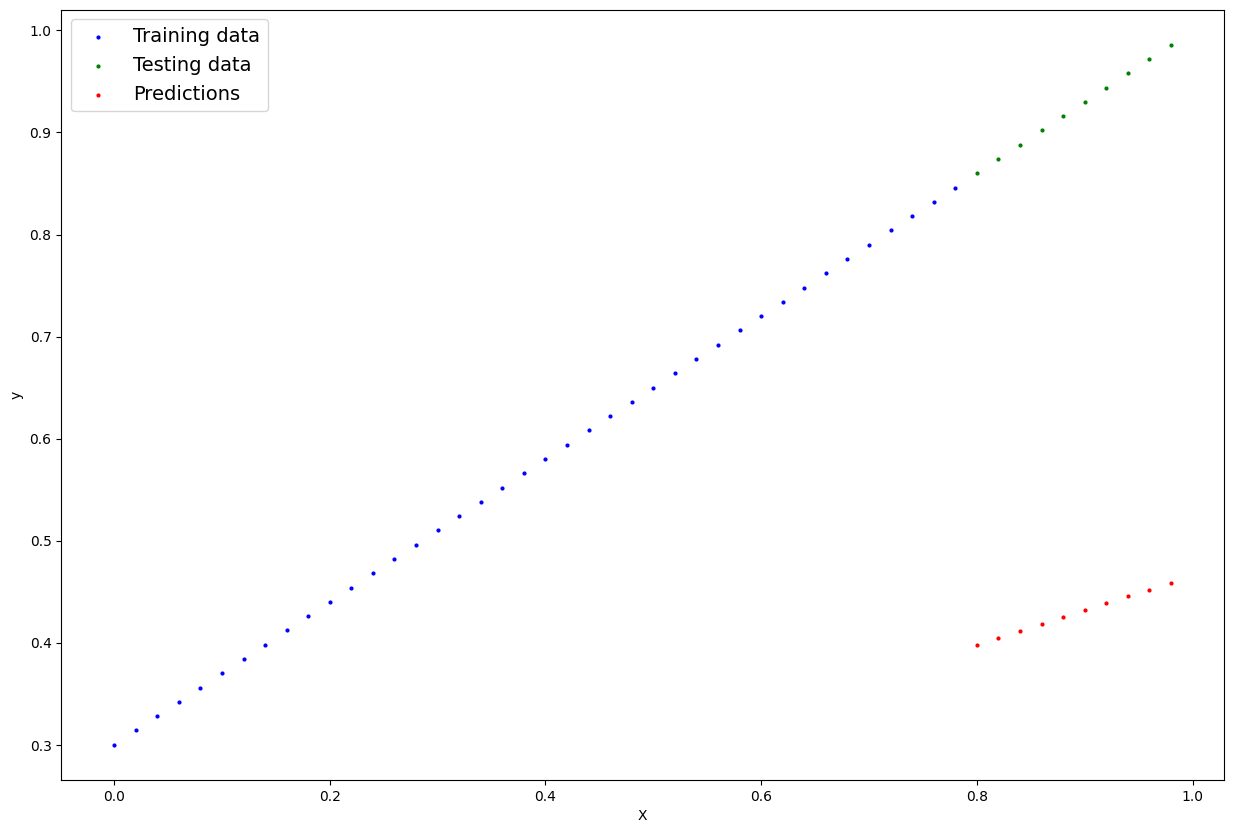

In [20]:
plot_predictions(predictions=y_preds)

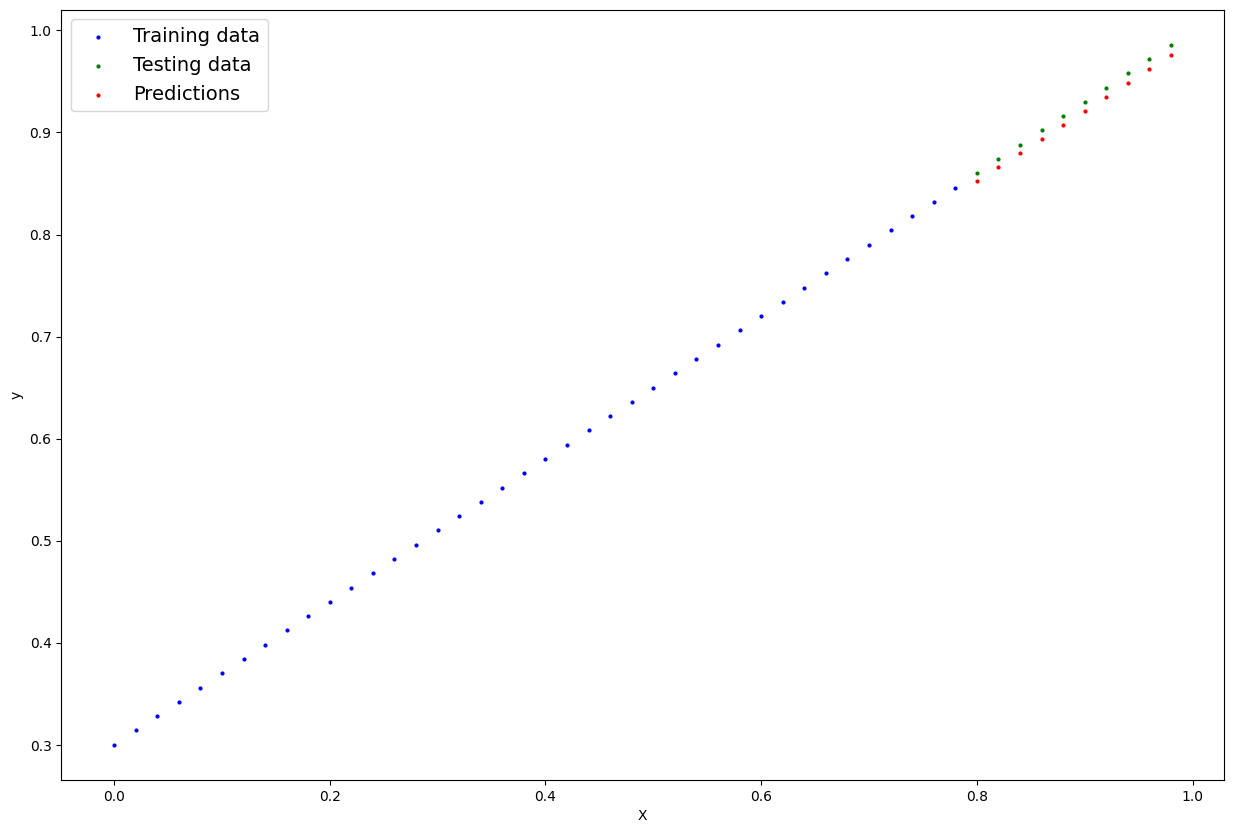

In [21]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are 3 main methods you should know about saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary

In [22]:
# Saving our PyTorch model

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pt


In [23]:
!ls -l models

total 4
-rw-r--r-- 1 root root 2101 Dec 12 05:36 01_pytorch_workflow_model.pt


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [24]:
model_0 = LinearRegressionModel()
model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [25]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6813])), ('bias', tensor([0.3078]))])

In [26]:
# Make some predictions with our loaded model
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8529],
        [0.8665],
        [0.8802],
        [0.8938],
        [0.9074],
        [0.9210],
        [0.9347],
        [0.9483],
        [0.9619],
        [0.9755]])

## 6. Putting it all together

In [27]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it(for potentially faster computing).

If no GPU is available, it is going to stick to CPU.

In [28]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 6.1 Data

In [29]:
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [30]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [31]:
def plot_predictions(train_data=X_train,
                     train_labels=X_test,
                     test_data=y_train,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label='Training data')
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
  plt.legend(prop={'size': 14})
  plt.xlabel('X')
  plt.ylabel('y')

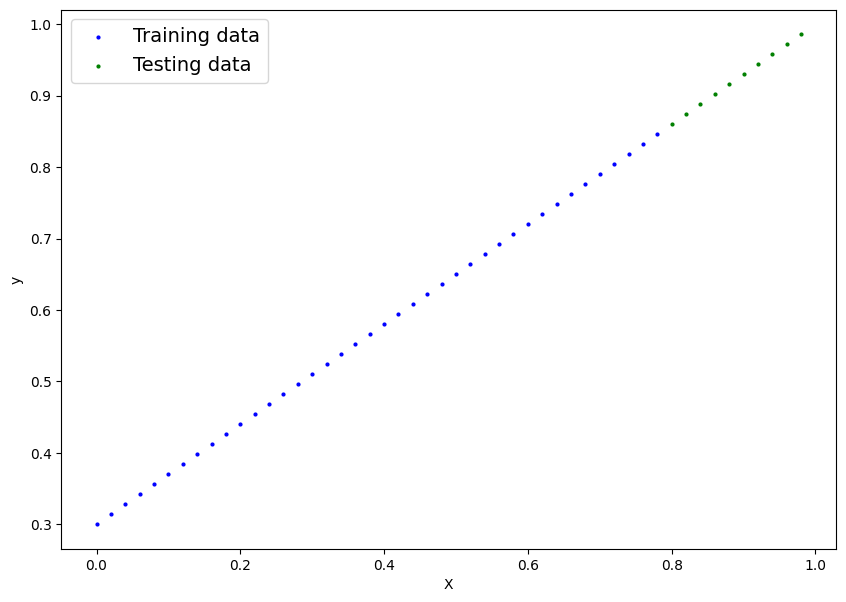

In [32]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch linear model

In [43]:
# Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [44]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]], device='cuda:0'),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]], device='cuda:0'))

In [45]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [46]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [47]:
# Setup loss function
loss_fn = nn.L1Loss() # same MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [48]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [49]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [50]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [51]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

### 6.5 Saving & loading a trained model

In [52]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVED_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving the model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVED_PATH)

Saving the model to: models/01_pytorch_workflow_model.pt


In [53]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [54]:
# Load a PyTorch model

# Create a new instance of linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVED_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [55]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [56]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [58]:
# Evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')